# 1 GMO

This section is not graded, and you do not need to submit your answers. But you are expected to consider these issues and be ready to discuss them.

## 1. GMO’s approach.

- (a) Why does GMO believe they can more easily predict long-run than short-run asset class performance?

<span style="color:red;">

Because they are betting on large factors that take time to play out. They also are analyzing series that have serial correlation, which have more predictive power over a longer time horizon.

</span>

- (b) What predicting variables does the case mention are used by GMO? Does this fit with the goal of long-run forecasts?

<span style="color:red;">

It uses some fundamental company variables such as:
* Dividend-Price Ratio
* Growth in sales per share
* Multiple Expansion
* Change in Profit Margin
* Macro Variables (GDP, inflation, corporate profits, etc.)

</span>

- (c) How has this approach led to contrarian positions?

<span style="color:red;">

Because they try to invest in value positions, which are relatively cheap at the time. They are cheap because they have not been recent winners. This leads to a sort of momentum consequence over the short-term which makes value investments look contrarian.

</span>

- (d) How does this approach raise business risk and managerial career risk?

<span style="color:red;">

Their signals lead them to invest like value investors. This means they are often investing in relatively cheap assets and betting that their value will mean revert. They must consequently lose money in the short-term to realize big returns on their contrarian bets.

</span>

## 2. The market environment.

- (a) We often estimate the market risk premium by looking at a large sample of historic data. What reasons does the case give to be skeptical that the market risk premium will be as high in the future as it has been over the past 50 years?

<span style="color:red;">



</span>

- (b) In 2007, GMO forecasts real excess equity returns will be negative. What are the biggest drivers of their pessimistic conditional forecast relative to the unconditional forecast. (See Exhibit 9.)

<span style="color:red;">



</span>

- (c) In the 2011 forecast, what components has GMO revised most relative to 2007? Now how does their conditional forecast compare to the unconditional? (See Exhibit 10.)

<span style="color:red;">



</span>

## 3. Consider the asset class forecasts in Exhibit 1.

- (a) Which asset class did GMO estimate to have a negative 10-year return over 2002-2011?

<span style="color:red;">



</span>

- (b) Which asset classes substantially outperformed GMO’s estimate over that time period?

<span style="color:red;">



</span>

- (c) Which asset classes substantially underperformed GMO’s estimate over that time period?

<span style="color:red;">



</span>

## 4. Fund Performance.

- (a) In which asset class was GMWAX most heavily allocated throughout the majority of 1997-2011?

<span style="color:red;">



</span>

- (b) Comment on the performance of GMWAX versus its benchmark. (No calculation needed; simply comment on the comparison in the exhibits.)

<span style="color:red;">



</span>

# 2 Analyzing GMO

In [67]:
import os
import sys
import pandas as pd
from scipy.stats import norm, chi2
import statsmodels.api as sm
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
grandparent_dir = os.path.abspath(os.path.join(parent_dir, os.pardir))
sys.path.insert(0, parent_dir)
sys.path.insert(0, grandparent_dir)
import cmds.portfolio_management_helper as pmh

plt.style.use("seaborn-v0_8-whitegrid")
PLOT_WIDTH, PLOT_HEIGHT = 8, 5
COLORS = ["blue", "red", "orange"]

warnings.filterwarnings('ignore')
pd.options.display.float_format = "{:.4f}".format
p = plt.rcParams

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This section utilizes data in the file, `gmo_data.xlsx`.

Examine GMO’s performance. Use the risk-free rate to convert the total returns to excess returns.

In [68]:
DATA_PATH = parent_dir + '/data/'
FILE_NAME = DATA_PATH + 'gmo_data.xlsx'
signals = pmh.read_excel_default(FILE_NAME, 
                                 sheet_name='signals',
                                 index_col='date', parse_dates=True)
rf_rets = pmh.read_excel_default(FILE_NAME, 
                                 sheet_name='risk-free rate',
                                 index_col='date', parse_dates=True)
rf_rets /= 12   # risk-free returns are originally provided on annualized
total_rets = pmh.read_excel_default(FILE_NAME, 
                                 sheet_name='total returns',
                                 index_col='date', parse_dates=True)
excess_rets = total_rets - rf_rets.values

,SPY,GMWAX,GMGEX
date,,,
1996-12-31,-0.0276,-0.0264,-0.0173
1997-01-31,0.0283,-0.0162,0.0123
1997-02-28,0.0337,0.0014,0.0208
1997-03-31,-0.0182,-0.0182,-0.0005
1997-04-30,0.0407,-0.0291,-0.0049
...,...,...,...
2024-06-28,5.5199,2.0087,-0.5381
2024-07-31,5.5702,2.0869,-0.5241
2024-08-30,5.6957,2.1191,-0.5168


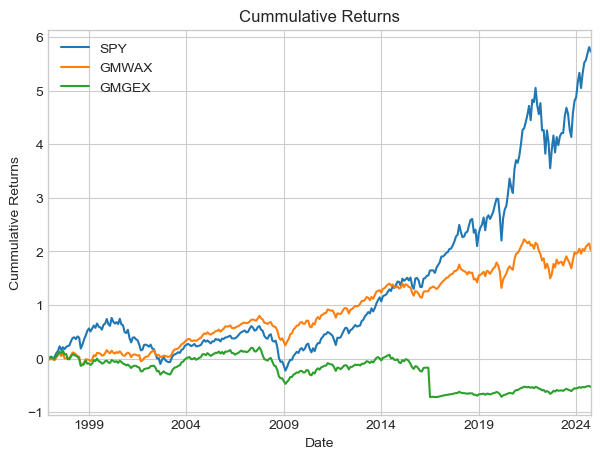

In [69]:
pmh.calc_cummulative_returns(excess_rets, return_series=True)

## 1. Calculate the mean, volatility, and Sharpe ratio for GMWAX. Do this for three samples:

- from inception through 2011
- 2012-present
- inception - present

In [93]:
macro_stats = pmh.calc_summary_statistics(excess_rets.GMWAX.to_frame('GMWAX'), annual_factor=12, provided_excess_returns=True, 
                            timeframes={'Inception-2011': ['1996', '2011'],
                                        '2012-Present': ['2012', '2024'],
                                        'Inception-Present': ['1996', '2024']},
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe']).T.style.format("{:.2%}")
macro_stats

,GMWAX Inception-2011,GMWAX 2012-Present,GMWAX Inception-Present
Annualized Mean,4.64%,4.34%,4.50%
Annualized Vol,11.05%,9.49%,10.35%
Annualized Sharpe,42.01%,45.73%,43.52%


Has the mean, vol, and Sharpe changed much since the case?

<span style="color:red;">

No, the mean, vol, and Sharpe ratios have not changed much since the case. The most meaningful change has been a drop in the volatility, though it is not substantial.

</span>

## 2. GMO believes a risk premium is compensation for a security’s tendency to lose money at “bad times”. For all three samples, analyze extreme scenarios by looking at:

- Min return
- 5th percentile (VaR-5th)
- Maximum drawdown

In [71]:
macro_risk = pmh.calc_summary_statistics(excess_rets.GMWAX.to_frame('GMWAX'), annual_factor=12, provided_excess_returns=True,
                            timeframes={'Inception-2011': ['1996', '2011'],
                                        '2012-Present': ['2012', '2024'],
                                        'Inception-Present': ['1996', '2024']},
                            keep_columns=['Min', 'VaR', 'Drawdown']).T.style.format("{:.2%}")
macro_risk

,GMWAX Inception-2011,GMWAX 2012-Present,GMWAX Inception-Present
Min,-14.92%,-11.50%,-14.92%
Historical VaR (5.00%),-4.40%,-4.09%,-4.14%
Annualized Historical VaR (5.00%),-15.24%,-14.15%,-14.33%
Historical CVaR (5.00%),-7.41%,-5.89%,-6.88%
Annualized Historical CVaR (5.00%),-25.66%,-20.39%,-23.85%
Max Drawdown,-30.65%,-22.56%,-30.65%


- (a) Does GMWAX have high or low tail-risk as seen by these stats?
- (b) Does that vary much across the two subsamples?

<span style="color:red;">

(a) GMWAX appears to have relatively average tail-risk. The monthly VaR is between 4-4.5% in each sample period, and the max drawdown is about 31% in the sample period that includes the GFC and about 23% in the sample period that includes COVID. These were periods of sharp drawdowns all across markets, but the max drawdown of the GMWAX fund appears fairly reasonable. 

(b) The tail risk does not vary that much across the two subsamples. While the VaR and drawdowns are less severe in the more recent sample period, it doesn't appear to be dramatically different.

</span>

## 3. For all three samples, regress excess returns of GMWAX on excess returns of SPY.

- (a) Report the estimated alpha, beta, and r-squared.
- (b) Is GMWAX a low-beta strategy? Has that changed since the case?
- (c) Does GMWAX provide alpha? Has that changed across the subsamples?

In [72]:
macro_regr = pmh.calc_regression(excess_rets['GMWAX'].to_frame('GMWAX'), excess_rets['SPY'].to_frame('SPY'), intercept=True, annual_factor=12,
                    timeframes={'Inception-2011': ['1996', '2011'],
                                '2012-Present': ['2012', '2024'],
                                'Inception-Present': ['1996', '2024']},
                    keep_columns=['R-Squared', 'Annualized Alpha', 'Beta']).T
macro_regr

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,GMWAX Inception-2011,GMWAX 2012-Present,GMWAX Inception-Present
Annualized Alpha,0.0270,-0.0340,0.0006
R-Squared,0.6487,0.7487,0.6802
SPY Beta,0.5421,0.5818,0.5526


<span style="color:red;">

(b) Yes, GMWAX is a low-beta strategy (i.e: market beta < 1). This has not changed since the case.

(c) In the first sample period (before the case) GMWAX does appear to provide ~2.5% alpha over the market. However, in the sample period following the case, GMWAX appears to provide negative alpha below the market return. Over the full sample period, GMWAX does not appear to provide alpha. 

</span>

## 4. Above, we’ve evaluated GMO’s macro fund, ”GMWAX”, as studied in the case. Now, consider GMO’s equity fund, ”GMGEX”.

Compute the performance stats of 3.1-3.3 for GMGEX. What are some of the major differences between these two strategies?

In [73]:
# Returns Statistics
display(macro_stats)
pmh.calc_summary_statistics(excess_rets.GMGEX.to_frame('GMGEX'), annual_factor=12, provided_excess_returns=True, 
                            timeframes={'Inception-2011': ['1996', '2011'],
                                        '2012-Present': ['2012', '2024'],
                                        'Inception-Present': ['1996', '2024']},
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe']).T.style.format("{:.2%}")

,GMWAX Inception-2011,GMWAX 2012-Present,GMWAX Inception-Present
Annualized Mean,4.64%,4.34%,4.50%
Annualized Vol,11.05%,9.49%,10.35%
Annualized Sharpe,42.01%,45.73%,43.52%


,GMGEX Inception-2011,GMGEX 2012-Present,GMGEX Inception-Present
Annualized Mean,-0.38%,0.13%,-0.15%
Annualized Vol,14.73%,23.56%,19.26%
Annualized Sharpe,-2.60%,0.56%,-0.76%


<span style="color:red;">

As we can see, the returns of the equity fund are considerably lower and show significantly greater volatility. Consequently, they have considerably worse risk-adjusted returns.

</span>

In [74]:
# Risk Statistics
display(macro_risk)
pmh.calc_summary_statistics(excess_rets.GMGEX.to_frame('GMGEX'), annual_factor=12, provided_excess_returns=True,
                            timeframes={'Inception-2011': ['1996', '2011'],
                                        '2012-Present': ['2012', '2024'],
                                        'Inception-Present': ['1996', '2024']},
                            keep_columns=['Min', 'VaR', 'Drawdown']).T.style.format("{:.2%}")

,GMWAX Inception-2011,GMWAX 2012-Present,GMWAX Inception-Present
Min,-14.92%,-11.50%,-14.92%
Historical VaR (5.00%),-4.40%,-4.09%,-4.14%
Annualized Historical VaR (5.00%),-15.24%,-14.15%,-14.33%
Historical CVaR (5.00%),-7.41%,-5.89%,-6.88%
Annualized Historical CVaR (5.00%),-25.66%,-20.39%,-23.85%
Max Drawdown,-30.65%,-22.56%,-30.65%


,GMGEX Inception-2011,GMGEX 2012-Present,GMGEX Inception-Present
Min,-15.16%,-65.89%,-65.89%
Historical VaR (5.00%),-8.23%,-6.80%,-7.62%
Annualized Historical VaR (5.00%),-28.51%,-23.57%,-26.40%
Historical CVaR (5.00%),-9.86%,-16.27%,-13.07%
Annualized Historical CVaR (5.00%),-34.14%,-56.35%,-45.28%
Max Drawdown,-56.40%,-73.83%,-76.81%


<span style="color:red;">

The risk of the equity fund is considerably greater than the macro fund. Very notable is extreme difference in the drawdowns in each of the subsamples, especially the more recent subsample.

</span>

In [75]:
# SPY Regression Statistics
display(macro_regr)
pmh.calc_regression(excess_rets['GMGEX'].to_frame('GMGEX'), excess_rets['SPY'].to_frame('SPY'), intercept=True, annual_factor=12,
                    timeframes={'Inception-2011': ['1996', '2011'],
                                '2012-Present': ['2012', '2024'],
                                'Inception-Present': ['1996', '2024']},
                    keep_columns=['R-Squared', 'Annualized Alpha', 'Beta']).T

,GMWAX Inception-2011,GMWAX 2012-Present,GMWAX Inception-Present
Annualized Alpha,0.0270,-0.0340,0.0006
R-Squared,0.6487,0.7487,0.6802
SPY Beta,0.5421,0.5818,0.5526


"calc_regression" assumes excess returns to calculate Information and Treynor Ratios


,GMGEX Inception-2011,GMGEX 2012-Present,GMGEX Inception-Present
Annualized Alpha,-0.0312,-0.1102,-0.0648
R-Squared,0.7259,0.2525,0.3979
SPY Beta,0.7642,0.8381,0.7867


<span style="color:red;">

The equity fund appears to provide consistently negative alpha across both sub-sample and across the full sample. However, it is also a higher beta strategy than the macro fund. Interestingly, the excess returns of the equity fund are "less explained" by SPY than the excess returns of the macro fund.

</span>

# 3 Forecast Regressions

This section utilizes data in the file, gmo data.xlsx.

## 1. Consider the lagged regression, where the regressor, ($X$,) is a period behind the target, ($r^{SPY}$ ).

$r_t^{SPY} = α^{SPY,X} + (β^{SPY,X})'X_{t−1} + ϵ_t^{SPY,X}$

Estimate (1) and report the $R^2$, as well as the OLS estimates for α and β. Do this for:

- X as a single regressor, the dividend-price ratio.
- X as a single regressor, the earnings-price ratio.
- X as three regressors, the dividend-price ratio, the earnings-price ratio, and the 10-year yield.

For each, report the r-squared.

In [76]:
div_price = pmh.calc_regression(excess_rets['SPY'].to_frame('SPY DVD YLD'), signals['SPX DVD YLD'].shift(1).to_frame('SPX'), 
                                intercept=True, annual_factor=12, warnings=False, keep_columns=['R-Squared'])
ear_price = pmh.calc_regression(excess_rets['SPY'].to_frame('SPY P/E'), signals['SPX P/E'].shift(1).to_frame('SPX'), 
                                intercept=True, annual_factor=12, warnings=False, keep_columns=['R-Squared'])
multi_reg = pmh.calc_regression(excess_rets['SPY'].to_frame('Multiple'), signals.shift(1), 
                                intercept=True, annual_factor=12, warnings=False, keep_columns=['R-Squared'])

pd.concat([div_price, ear_price, multi_reg], axis=0).style.format("{:.2%}")

,R-Squared
SPY DVD YLD,1.40%
SPY P/E,0.60%
Multiple,1.65%


## 2. For each of the three regressions, let’s try to utilize the resulting forecast in a trading strategy.

- Build the forecasted SPY returns: $r̂_{t+1}^{SPY}$ . Note that this denotes the forecast made using $X_t$ to forecast the (t+ 1) return.

- Set the scale of the investment in SPY equal to 100 times the forecasted value:

$w_t = 100 r̂_{t+1}^{SPY}$

In [77]:
div_price = pmh.calc_regression(excess_rets['SPY'].to_frame('SPY DVD YLD'), signals['SPX DVD YLD'].shift(1).to_frame('SPX'), 
                                intercept=True, return_model=True, warnings=False)
ear_price = pmh.calc_regression(excess_rets['SPY'].to_frame('SPY P/E'), signals['SPX P/E'].shift(1).to_frame('SPX'), 
                                intercept=True, return_model=True, warnings=False)
multi_reg = pmh.calc_regression(excess_rets['SPY'].to_frame('Multiple'), signals.shift(1), 
                                intercept=True, return_model=True, warnings=False)

strats = pd.DataFrame({'div_price': (excess_rets['SPY'] - div_price.resid).dropna() * 100,
                       'ear_price': (excess_rets['SPY'] - ear_price.resid).dropna() * 100,
                       'multi_reg': (excess_rets['SPY'] - multi_reg.resid).dropna() * 100})
strats

Regression assumes 'annual_factor' equals to 12 since it was not provided
Regression assumes 'annual_factor' equals to 12 since it was not provided
Regression assumes 'annual_factor' equals to 12 since it was not provided


,div_price,ear_price,multi_reg
date,,,
1997-01-31,0.8785,0.6878,0.4265
1997-02-28,0.7208,0.5916,0.2925
1997-03-31,0.7270,0.5815,0.2926
1997-04-30,0.8490,0.7860,0.2949
1997-05-30,0.7175,0.6947,0.2243
...,...,...,...
2024-06-28,0.0847,0.2897,0.0766
2024-07-31,0.0372,0.2181,0.0682
2024-08-30,0.0285,0.1974,0.1218


We are not taking this scaling too seriously. We just want the strategy to go bigger in periods where the forecast is high and to withdraw in periods where the forecast is low, or even negative.

- Calculate the return on this strategy:

$r_{t+1}^x = w_t r_{t+1}^{SPY}$

In [78]:
strats = strats.multiply(excess_rets['SPY'], axis=0).dropna()
strats

,div_price,ear_price,multi_reg
date,,,
1997-01-31,0.0505,0.0395,0.0245
1997-02-28,0.0038,0.0031,0.0015
1997-03-31,-0.0365,-0.0292,-0.0147
1997-04-30,0.0509,0.0472,0.0177
1997-05-30,0.0424,0.0411,0.0133
...,...,...,...
2024-06-28,0.0026,0.0089,0.0024
2024-07-31,0.0003,0.0017,0.0005
2024-08-30,0.0005,0.0038,0.0023


You should now have the trading strategy returns, $r^x$ for each of the forecasts. For each strategy, estimate:

- mean, volatility, Sharpe,
- max-drawdown
- market alpha
- market beta
- market Information ratio

In [79]:
# Return Statistics
pmh.calc_summary_statistics(strats, annual_factor=12, provided_excess_returns=True,
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe']).T.style.format("{:.2%}")

,div_price,ear_price,multi_reg
Annualized Mean,8.91%,7.00%,9.49%
Annualized Vol,16.54%,12.33%,16.53%
Annualized Sharpe,53.88%,56.79%,57.39%


In [80]:
# Risk Statistics
pmh.calc_summary_statistics(strats, annual_factor=12, provided_excess_returns=True,
                            keep_columns=['Min', 'VaR', 'Drawdown']).T.style.format("{:.2%}")

,div_price,ear_price,multi_reg
Min,-29.92%,-17.51%,-27.75%
Historical VaR (5.00%),-4.92%,-4.94%,-4.75%
Annualized Historical VaR (5.00%),-17.04%,-17.10%,-16.47%
Historical CVaR (5.00%),-10.70%,-8.40%,-10.63%
Annualized Historical CVaR (5.00%),-37.08%,-29.11%,-36.82%
Max Drawdown,-72.44%,-55.90%,-67.85%


In [81]:
# Market Regression Stats
pmh.calc_iterative_regression(strats, excess_rets['SPY'].iloc[:-1].to_frame('SPY'), intercept=True, annual_factor=12,
                    keep_columns=['Annualized Alpha', 'Beta', 'Annualized Information']).T

"calc_regression" assumes excess returns to calculate Information and Treynor Ratios
"div_price" Required to reset indexes to make regression work. Try passing "y" and "X" as pd.DataFrame


,div_price,ear_price,multi_reg
Annualized Alpha,0.0836,0.0683,0.0902
SPY Beta,0.0676,0.0213,0.0569
Annualized Information Ratio,0.5066,0.5541,0.5468


## 3. GMO believes a risk premium is compensation for a security’s tendency to lose money at “bad times”. Let’s consider risk characteristics.

- (a) For both strategies, the market, and GMO, calculate the monthly VaR for π = .05. Just use the quantile of the historic data for this VaR calculation.
- (b) The GMO case mentions that stocks under-performed short-term bonds from 2000-2011. Does the dynamic portfolio above under-perform the risk-free rate over this time?
- (c) Based on the regression estimates, in how many periods do we estimate a negative risk premium?
- (d) Do you believe the dynamic strategy takes on extra risk?

In [82]:
# (a) For both strategies, the market, and GMO, calculate the monthly VaR for π = .05. 
# Just use the quantile of the historic data for this VaR calculation.
compare_df = pd.concat([strats, excess_rets], axis=1).dropna()
pmh.calc_summary_statistics(compare_df, annual_factor=12, provided_excess_returns=True, 
                            keep_columns=['Annualized Historical VaR']).style.format("{:.2%}")

,Annualized Historical VaR (5.00%)
div_price,-17.04%
ear_price,-17.10%
multi_reg,-16.47%
SPY,-27.60%
GMWAX,-14.34%
GMGEX,-26.43%


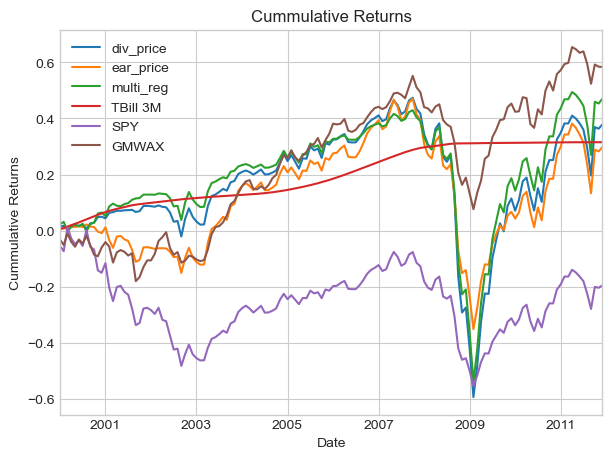

In [83]:
# (b) The GMO case mentions that stocks under-performed short-term bonds from 2000-2011. 
# Does the dynamic portfolio above under-perform the risk-free rate over this time?
pmh.calc_cummulative_returns(pd.concat([strats['2000':'2011'], 
                                        rf_rets['2000':'2011'], 
                                        excess_rets.loc['2000':'2011', ['SPY', 'GMWAX']]], axis=1))


<span style="color:red;">

It appears that the dynamic portfolio derived from the regression using the SPX P/E only as the regressor does underperform the risk-free rate over the period from 2000-2011. However, it does not underperform as much as stocks did (as represented by the SPY index).

</span>

In [84]:
# (c) Based on the regression estimates, in how many periods do we estimate a negative risk premium?
full_sample = (strats < 0).mean().to_frame('% Negative Risk Premium Periods')
sub_sample = (strats['2000':'2011'] < 0).mean().to_frame('% Negative Risk Premium Periods')

pd.concat({'Full Sample': full_sample, '2000-2011': sub_sample}, axis=0).style.format("{:.2%}")

<span style="color:red;">

(d) I do believe the dynamic strategy takes on extra risk relative to the risk-free rate. This belief is clearly evidenced by the cumulative return plot above. While the risk-free rate offers steady predictable period-over-period returns, the strategy exhibits quite a bit more volatility. It also has some substantial periods of drawdown that investors would likely want to be compensated for.

</span>

# 4 Out-of-Sample Forecasting

This section utilizes data in the file, `gmo_data.xlsx`.

Reconsider the problem above, of estimating (1) for x. The reported R2 was the in-sample R2–it examined how well the forecasts fit in the sample from which the parameters were estimated.

In particular, focus on the case of using both dividend-price and earnings-price as signals.

Let’s consider the out-of-sample r-squared. To do so, we need to do the following:

- Start at t = 60.
- Estimate (1) only using data through time t.
- Use the estimated parameters of (1), along with $x_{t+1}$ to calculate the out-of-sample forecast for the following period, t+ 1.

$$r̂_{t+1}^{SPY} = α̂_t^{SPY,x} + (β^{SPY,x})' \mathbf{x_t}$$

- Calculate the t+ 1 forecast error,

$$e_{t+1}^{forecast} = r_{t+1}^{SPY} − r̂_{t+1}^{SPY}$$

- Move to t = 61, and loop through the rest of the sample.

You now have the time-series of out-of-sample prediction errors, ex.

Calculate the time-series of out-of-sample prediction errors $e^{null}$, which are based on the null forecast:

$$r̄_{t+1}^{SPY} = \frac{1}{t}∑_{i=1}^t r_i^{SPY}$$

$$e_{t+1}^{null} =r_{t+1}^{SPY} − r̄_{t+1}^{SPY}$$

## 1. Report the out-of-sample R2:

$$\mathcal{R}_{OOS}^2 ≡ 1−\frac{∑_{i=61}^T(e_i^{forecast})^2}{(∑_{i=61}^T(e_i^{null})^2)}$$

Note that unlike an in-sample r-squared, the out-of-sample r-squared can be anywhere between (−∞, 1].

Did this forecasting strategy produce a positive OOS r-squared?

In [85]:
y = excess_rets['SPY']
X = signals.shift(1)[['SPX DVD YLD', 'SPX P/E']]
X = sm.add_constant(X)
start = 60
forecast_errors, null_errors = [], []

for i in range(start, len(y)-1):
    y_i = y.iloc[:i]
    X_i = X.iloc[:i]
    model = sm.OLS(y_i, X_i, missing='drop').fit()
    pred_i = model.predict(X.iloc[i+1])[0]
    forecast_errors.append(y.iloc[i+1] - pred_i)
    null_errors.append(y.iloc[i+1] - y.iloc[:i].mean())

print(f'OOS R-Squared: {1 - np.sum(np.square(forecast_errors)) / np.sum(np.square(null_errors)):.2%}')

OOS R-Squared: -8.69%


## 2. Re-do problem 3.2 using this OOS forecast.

How much better/worse is the OOS strategy compared to the in-sample version of 3.2?

In [88]:
oos_rets = (excess_rets.iloc[start+1:, 0] - forecast_errors).to_frame('oos_rets') * 100
oos_rets = oos_rets.multiply(excess_rets['SPY'], axis=0).dropna()
new_strats = pd.concat([strats, oos_rets], axis=1).dropna()

# Return & Risk Statistics
pmh.calc_summary_statistics(new_strats, annual_factor=12, provided_excess_returns=True,
                            keep_columns=['Annualized Mean', 'Annualized Vol', 'Annualized Sharpe',
                                          'Min', 'Annualized Historical VaR', 'Drawdown']).T.style.format("{:.2%}")

,div_price,ear_price,multi_reg,oos_rets
Annualized Mean,9.30%,7.43%,10.56%,1.94%
Annualized Vol,18.09%,13.16%,18.14%,23.61%
Annualized Sharpe,51.45%,56.47%,58.24%,8.21%
Min,-29.92%,-17.51%,-27.75%,-58.36%
Annualized Historical VaR (5.00%),-18.62%,-21.07%,-19.26%,-24.97%
Max Drawdown,-72.44%,-55.90%,-67.85%,-87.00%


<span style="color:red;">

The performance of the OOS strategy is substantially worse than the in-sample version calculated in 3.2 (as evidenced by the final column in the above dataframe). The return profile is considerably worse (Sharpe less than 1/7 the in-sample performance) and the tail risk is substantially larger.

</span>

## 3. Re-do problem 3.3 using this OOS forecast.

Is the point-in-time version of the strategy riskier?

In [89]:
# (a) For both strategies, the market, and GMO, calculate the monthly VaR for π = .05. 
# Just use the quantile of the historic data for this VaR calculation.
compare_df = pd.concat([new_strats, excess_rets], axis=1).dropna()
pmh.calc_summary_statistics(compare_df, annual_factor=12, provided_excess_returns=True, 
                            keep_columns=['Annualized Historical VaR']).style.format("{:.2%}")

,Annualized Historical VaR (5.00%)
div_price,-18.62%
ear_price,-21.07%
multi_reg,-19.26%
oos_rets,-24.97%
SPY,-26.57%
GMWAX,-14.25%
GMGEX,-26.43%


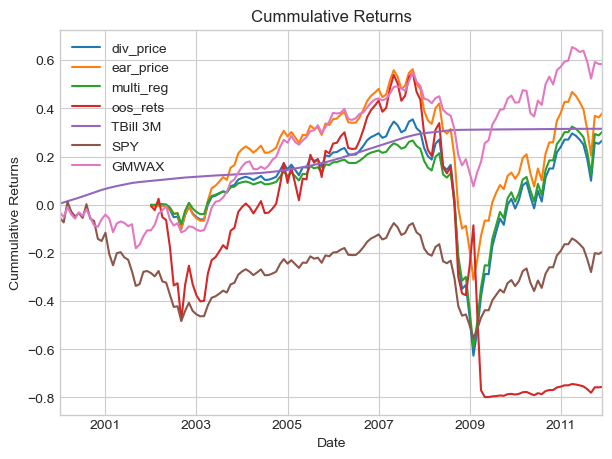

In [90]:
# (b) The GMO case mentions that stocks under-performed short-term bonds from 2000-2011. 
# Does the dynamic portfolio above under-perform the risk-free rate over this time?
pmh.calc_cummulative_returns(pd.concat([new_strats['2000':'2011'], 
                                        rf_rets['2000':'2011'], 
                                        excess_rets.loc['2000':'2011', ['SPY', 'GMWAX']]], axis=1))

In [91]:
# (c) Based on the regression estimates, in how many periods do we estimate a negative risk premium?
full_sample = (new_strats < 0).mean().to_frame('% Negative Risk Premium Periods')
sub_sample = (new_strats['2000':'2011'] < 0).mean().to_frame('% Negative Risk Premium Periods')

pd.concat({'Full Sample': full_sample, '2000-2011': sub_sample}, axis=0).style.format("{:.2%}")

# 5 Extensions

This section is not graded, and you do not need to submit your answers. We may discuss some of these extensions.

## 1. Classification and Regression Tree (CART)

Re-do Section 3, but use CART in forecasting instead of a lagged regression.

- Consider using RandomForestRegressor from sklearn.ensemble.
- If you want to plot the tree, try using tree from sklearn.

## 2. Expand on the CART analysis by calculating the OOS stats, as in Section 4.

## 3. Re-do Section 3, but use a Neural Network in forecasting instead of a lagged regression.

- Consider using MLPRegressor from sklearn.neural network.

## 4. Expand on the CART and Neural Network analysis by calculating the OOS stats, as in Section 4.